In [103]:
from db_env import DbEnv,db
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from matplotlib import cm

In [104]:
conn, cursor = DbEnv().connect_sql()
sql = "SELECT DISTINCT num FROM daily_music_cow"
num_list = DbEnv().get_data_from_table(cursor, sql)
num_list = [item[0] for item in num_list]
print(num_list)

[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 110, 111, 112, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 163, 164, 165, 167, 168, 169, 171, 173, 174, 175, 176, 177, 178, 179, 180, 183, 184, 185, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197, 198, 199, 202, 204, 206, 207, 208, 211, 212, 216, 218, 219, 221, 224, 225, 230, 231, 233, 237, 238, 240, 258, 261, 262, 265, 267, 274, 311, 322, 345, 373, 382, 420, 460, 461, 462, 464, 465, 466, 467, 468, 469, 470, 471, 472, 474, 475, 477, 478, 479, 480, 481, 482, 483, 484, 485

### 데이터프레임화

In [105]:
df_price, df_mcpi = pd.DataFrame(), pd.DataFrame()

# find shortest date length to fit all songs
for num in num_list:
    sql = "SELECT date, price FROM daily_music_cow WHERE num = %s" % num
    df_temp = db(cursor, sql).dataframe
    df_temp = df_temp.set_index('date')
    df_temp.columns = ["%d" % num]

    df_price = pd.concat([df_price, df_temp], axis=1)

print(df_price)
df_price.to_pickle("./storage/df_price.pkl")

               26     27     28     29     30     31     32     33     34  \
date                                                                        
2021-06-03  29000  26000  24000  52800  13500  16100  10300  14500  36400   
2021-06-04  29000  26000  24000  52800  13500  16100  10300  14500  36400   
2021-06-05  29000  26000  23700  52800  13500  16100  10800  14500  36400   
2021-06-06  28500  26000  23500  52800  13500  16100  10800  14500  36400   
2021-06-07  29100  26000  24900  52800  13500  15100  10800  14500  36400   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2021-11-23  29000  43000  29800  90700  19100  70100  15100  37200  40000   
2021-11-24  28500  43000  29900  90700  19100  70000  15000  37200  40000   
2021-11-25  27900  43000  29800  90700  19100  70000  15000  37200  40000   
2021-11-26  30000  43000  31200  90700  19100  70000  15000  37200  40000   
2021-11-27  27000  43000  29100  90700  19000  70000  16100  37200  40000   

In [106]:
sql = "SELECT date, price FROM daily_mcpi"
df_mcpi = db(cursor, sql).dataframe
df_mcpi = df_mcpi.set_index('date')
df_mcpi.columns = [0]

print(df_mcpi)
df_mcpi.to_pickle("./storage/df_mcpi.pkl")

                 0
date              
2021-12-08  246.43
2021-12-07  247.01
2021-12-06  246.48
2021-12-05  246.18
2021-12-04  245.84
...            ...
2019-03-24   83.54
2019-03-23   83.59
2019-03-22   83.44
2019-03-21   82.88
2019-03-20   82.59

[995 rows x 1 columns]


In [107]:
# 결측치 제거를 통해 date 맞춰주기
df_price = pd.read_pickle('./storage/df_price.pkl')
df_mcpi = pd.read_pickle('./storage/df_mcpi.pkl')

df_price = pd.concat([df_mcpi, df_price], axis=1)

df_price_droped = df_price.dropna(axis=0)
df_price_droped = df_price_droped.sort_index(ascending=True)
list_price_droped = list(df_price_droped.columns)

print(df_price_droped)

                 0       26       27       28       29       30       31  \
date                                                                       
2021-07-06  189.31  24000.0  23000.0  19000.0  60500.0  12900.0  22000.0   
2021-07-07  189.07  24000.0  23000.0  19000.0  60500.0  12900.0  22000.0   
2021-07-08  187.87  24000.0  23000.0  19000.0  60500.0  12900.0  22000.0   
2021-07-09  187.28  23900.0  23000.0  17800.0  60500.0  12900.0  22000.0   
2021-07-10  187.98  23800.0  17000.0  16600.0  60500.0  12900.0  22000.0   
...            ...      ...      ...      ...      ...      ...      ...   
2021-11-23  247.03  29000.0  43000.0  29800.0  90700.0  19100.0  70100.0   
2021-11-24  246.02  28500.0  43000.0  29900.0  90700.0  19100.0  70000.0   
2021-11-25  245.77  27900.0  43000.0  29800.0  90700.0  19100.0  70000.0   
2021-11-26  242.78  30000.0  43000.0  31200.0  90700.0  19100.0  70000.0   
2021-11-27  243.98  27000.0  43000.0  29100.0  90700.0  19000.0  70000.0   

           

In [108]:
# MinMaxScaler로 정규화
array_price_scaled = MinMaxScaler().fit_transform(df_price_droped)
df_price_scaled = pd.DataFrame(array_price_scaled)
df_price_scaled.columns = list_price_droped
df_price_scaled.index = df_price_droped.index
print(df_price_scaled)

# num=0(MCPI) 지수 df에서 제거
df_mcpi = df_price_scaled[df_price_scaled.columns[0]]
df_price_scaled = df_price_scaled.drop(df_price_scaled.columns[0], axis='columns')

print(df_mcpi)

                   0        26        27        28        29        30  \
date                                                                     
2021-07-06  0.033448  0.018939  0.197015  0.067797  0.159490  0.063348   
2021-07-07  0.032253  0.018939  0.197015  0.067797  0.159490  0.063348   
2021-07-08  0.026280  0.018939  0.197015  0.067797  0.159490  0.063348   
2021-07-09  0.023344  0.015152  0.197015  0.033898  0.159490  0.063348   
2021-07-10  0.026828  0.011364  0.017910  0.000000  0.159490  0.063348   
...              ...       ...       ...       ...       ...       ...   
2021-11-23  0.320741  0.208333  0.794030  0.372881  0.400319  0.156863   
2021-11-24  0.315714  0.189394  0.794030  0.375706  0.400319  0.156863   
2021-11-25  0.314469  0.166667  0.794030  0.372881  0.400319  0.156863   
2021-11-26  0.299587  0.246212  0.794030  0.412429  0.400319  0.156863   
2021-11-27  0.305560  0.132576  0.794030  0.353107  0.400319  0.155354   

                  31        32       

In [109]:
#데이터 프레임 전치
df_transed = df_price_scaled.transpose()

### 알맞은 군집 개수 확인

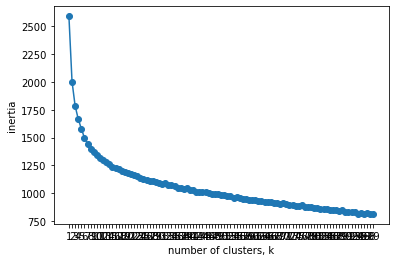

In [110]:
ks = range(1,100)
inertias = []

for k in ks:

    model = KMeans(n_clusters=k)
    model.fit(df_transed)
    inertias.append(model.inertia_)

# Plot ks vs inertias
plt.plot(figsize = (25,25))
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()


In [111]:
#실루엣 계수 함수

def plotSilhouette(X,y_km):
  plt.figure(figsize=(12,9))
  cluster_labels=np.unique(y_km)
  n_clusters=cluster_labels.shape[0]
  silhouette_vals=silhouette_samples(X,y_km,metric='euclidean')
  y_ax_lower, y_ax_upper=0,0
  yticks=[]

  for i,c in enumerate(cluster_labels):
    c_silhouette_vals=silhouette_vals[y_km==c]
    c_silhouette_vals.sort()
    y_ax_upper+=len(c_silhouette_vals)
    color=cm.jet(i/n_clusters)

    plt.barh(range(y_ax_lower,y_ax_upper),c_silhouette_vals, height=1.0, edgecolor='none', color=color)
    yticks.append((y_ax_lower+y_ax_upper)/2)
    y_ax_lower+=len(c_silhouette_vals)

  silhouette_avg=np.mean(silhouette_vals)
  plt.axvline(silhouette_avg,color='red',linestyle='--')
  plt.yticks(yticks, cluster_labels+1)
  plt.ylabel('클러스터')
  plt.xlabel('실루엣 계수')
  plt.show()

In [115]:
model = KMeans(6,max_iter=300, init='k-means++')
label = model.fit_predict(df_transed)
label

array([0, 1, 4, 5, 3, 3, 4, 5, 2, 5, 4, 2, 5, 1, 5, 0, 1, 1, 4, 1, 1, 5,
       0, 5, 5, 1, 0, 0, 5, 5, 3, 5, 0, 4, 5, 2, 1, 3, 4, 0, 0, 1, 0, 5,
       0, 1, 0, 4, 3, 2, 4, 3, 4, 4, 4, 4, 4, 5, 3, 0, 1, 4, 4, 4, 5, 4,
       4, 0, 1, 4, 2, 1, 1, 2, 0, 0, 0, 4, 4, 4, 4, 4, 0, 2, 4, 4, 4, 1,
       0, 1, 4, 0, 0, 2, 5, 4, 1, 5, 4, 4, 1, 4, 0, 4, 4, 4, 1, 0, 3, 4,
       0, 0, 4, 4, 5, 2, 4, 1, 1, 2, 0, 4, 4, 1, 4, 4, 0, 4, 0, 0, 4, 4,
       0, 4, 0, 5, 0, 1, 4, 4, 4, 1, 5, 5, 4, 1, 2, 1, 4, 0, 0, 4, 5, 3,
       0, 0, 3, 0, 3, 5, 0, 1, 2, 3, 4, 5, 4, 3, 0, 4, 2, 1, 2, 0, 1, 4,
       5, 4, 3, 5, 3, 0, 4, 2, 1, 5, 5, 1, 1, 4, 5, 5, 4, 4, 0, 0, 1, 0,
       1, 4, 3, 4, 4, 4, 4, 1, 2, 0, 0, 1, 0, 0, 3, 4, 2, 1, 4, 2, 1, 5,
       1, 1, 4, 4, 2, 5, 0, 5, 2, 1, 0, 5, 5, 4, 0, 4, 5, 4, 4, 5, 3, 4,
       5, 4, 5, 0, 4, 3, 4, 0, 4, 3, 5, 0, 2, 4, 1, 1, 3, 0, 4, 2, 0, 4,
       1, 1, 0, 0, 0, 0, 0, 1, 5, 4, 0, 3, 0, 1, 2, 0, 0, 4, 2, 0, 4, 1,
       4, 4, 4, 2, 4, 4, 4, 0, 4, 5, 5, 2, 1, 2, 4,

### 실루엣 계수 확인

C:\Users\ezmedicom\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ezmedicom\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 47336 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ezmedicom\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50659 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ezmedicom\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 44228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ezmedicom\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ezmedicom\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Gl

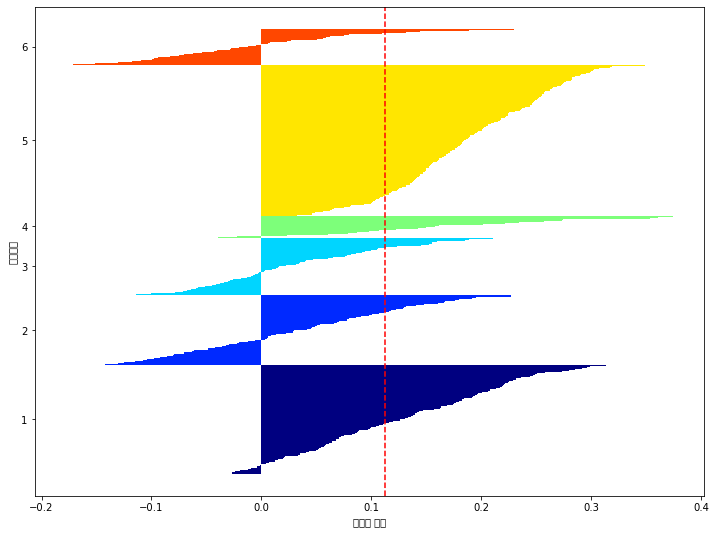

In [116]:
plotSilhouette(df_transed,label)

### 군집 시각화

<ipython-input-117-ef60575fa69e>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(5,2,i+1)


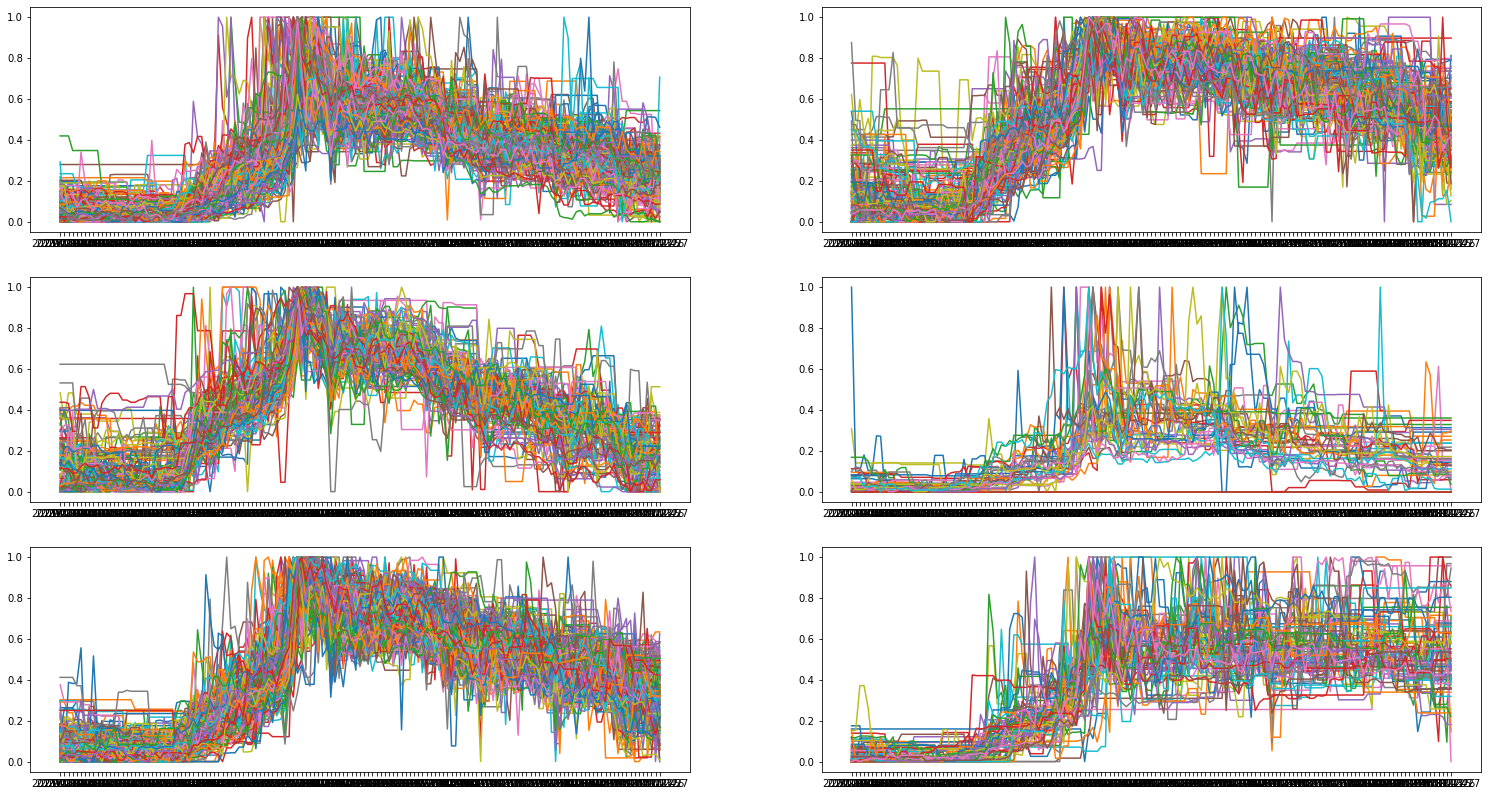

In [117]:
plt.figure(figsize=(26,24))
for idx,i in enumerate(label):
    plt.subplot(5,2,i+1)
    plt.plot(df_transed.iloc[idx])